# Supervised Customer Segmentation (Risk Bands via Logistic Regression)

This notebook builds supervised segments for unbanked customers so that each segment has a meaningfully different bad rate (target = 1) and is easy to interpret and deploy.

Approach:
1. Load the prepared dataset `unbanked_customer_segmentation_final.csv` (final shape ≈ 50,091 × 8).
2. Train a Logistic Regression model to produce probabilities of bad (risk scores in [0, 1]).
3. Segment customers into fixed score bands (e.g., [0–0.2), [0.2–0.4), [0.4–0.6), [0.6–0.8), [0.8–1.0]). Bands are ordered: Band 1 ≈ best (lowest risk), Band 5 ≈ worst (highest risk).
4. Produce detailed summaries for each band: size, % of portfolio, bad rate, lift vs overall, numeric feature means, categorical modes & distributions, and confidence intervals.
5. Run statistical tests (global chi-square + pairwise two-proportion z-tests with FDR) to verify significance of bad-rate differences across bands.
6. Export band assignments, profiles, tests, plots, and model artifacts.

You can adjust band cut points to change the granularity of segments. All steps are encapsulated in reusable functions where possible.

In [17]:
# Imports & Data Load
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OrdinalEncoder
from scipy import stats
import json
import math

# Reusable utilities
from utiles import (
    prepare_features,
    proportion_ci_wilson,
    compute_cluster_profiles,
    chi_square_test_cluster_target,
    pairwise_bad_rate_ztests,
)

DATA_PATH = Path('customer_segmantation_unbaked_dtree_v1.0/data/unbanked_customer_segmentation_final.csv')
assert DATA_PATH.exists(), f"Dataset file not found: {DATA_PATH}"

df = pd.read_csv(DATA_PATH)
print('Loaded shape:', df.shape)

# Basic schema validation based on documentation
expected_cols = {'customer_id','age','marital_status','income_delta_percentage','address_category','jobtitle_category','gender','target'}
missing = expected_cols - set(df.columns)
assert not missing, f"Missing expected columns: {missing}"

# Ensure target is binary 0/1
assert set(df['target'].unique()) <= {0,1}, 'Target must be binary 0/1'

overall_bad_rate = df['target'].mean()
print(f"Overall bad rate: {overall_bad_rate:.2%}")

df.head()

Loaded shape: (50091, 8)
Overall bad rate: 13.79%


,customer_id,age,marital_status,income_delta_percentage,address_category,jobtitle_category,gender,target
0,237305,57,Married,-18.367347,B,D,MALE,0
1,237305,57,Married,-18.367347,B,D,MALE,0
2,237318,42,Married,-62.962963,B,A,MALE,0
3,237324,25,Married,5.820106,D,A,MALE,0
4,237324,25,Married,5.820106,D,A,MALE,0


In [18]:
# Features & splits via utilities
from typing import Tuple, Dict

categorical_cols = ['marital_status','address_category','jobtitle_category','gender']
numeric_cols = ['age','income_delta_percentage']

# Prepare X, y, feature names, and fitted encoder
X, y, feature_names, enc = prepare_features(
    df, categorical_cols=categorical_cols, numeric_cols=numeric_cols, target_col='target'
 )

# Train/validation split (stratified to keep overall rate)
X_train, X_val, y_train, y_val, df_train_idx, df_val_idx = train_test_split(
    X, y, df.index, test_size=0.3, random_state=42, stratify=y
)

print('Prepared data dimensions:', X.shape)

Prepared data dimensions: (50091, 6)


In [19]:
# Data-driven banding that maximizes significant bad-rate differences between adjacent bands
import numpy as np
import pandas as pd
from scipy import stats


def _two_prop_pval(bad1: int, n1: int, bad2: int, n2: int) -> float:
    # Pooled two-proportion z-test, two-sided
    if n1 == 0 or n2 == 0:
        return 1.0
    p1, p2 = bad1 / n1, bad2 / n2
    p_pool = (bad1 + bad2) / (n1 + n2)
    se = np.sqrt(p_pool * (1 - p_pool) * (1 / n1 + 1 / n2))
    if se == 0:
        # If both perfectly 0 or 1, treat as no evidence if equal else strong difference
        return 1.0 if p1 == p2 else 0.0
    z = (p1 - p2) / se
    return float(2 * (1 - stats.norm.cdf(abs(z))))


def _compute_bins(df: pd.DataFrame, score_col: str, target_col: str, edges: np.ndarray) -> pd.DataFrame:
    cats = pd.cut(df[score_col], bins=edges, right=False, include_lowest=True)
    agg = df.groupby(cats)[target_col].agg(["sum", "count"]).rename(columns={"sum": "bad", "count": "n"})
    out = agg.reset_index()
    out["left"] = out[score_col].apply(lambda iv: iv.left)
    out["right"] = out[score_col].apply(lambda iv: iv.right)
    out["rate"] = out["bad"] / out["n"].where(out["n"] > 0, np.nan)
    return out[["left", "right", "bad", "n", "rate"]]


def make_significant_pd_bands(
    df: pd.DataFrame,
    score_col: str = "pd_score",
    target_col: str = "target",
    *,
    init_bins: int = 20,
    max_bands: int = 8,
    min_bin_size: float = 0.05,  # fraction of total rows per band
    alpha: float = 0.05,
) -> np.ndarray:
    """
    Create PD score bands by iteratively merging adjacent bins until:
    - All adjacent bad-rate differences are statistically significant (two-proportion z-test, p < alpha),
    - Each band has at least `min_bin_size` fraction of the portfolio, and
    - The number of bands <= `max_bands`.

    Returns the bin edges array suitable for pd.cut(..., bins=edges, right=False).
    """
    s = df[score_col].astype(float).values
    n_total = len(df)
    if n_total == 0:
        return np.array([0.0, 1.0000001])

    # Initial edges via quantiles (equal-frequency), dropping duplicates
    n_unique = int(pd.Series(s).nunique(dropna=True))
    nb = max(1, min(init_bins, n_unique))
    qs = np.linspace(0, 1, nb + 1)
    edges = np.quantile(s, qs)
    edges = np.unique(edges)

    # Ensure at least a single interval and open-right top edge
    smin, smax = float(np.nanmin(s)), float(np.nanmax(s))
    if edges[0] > smin:
        edges[0] = smin
    if edges[-1] < smax:
        # bump top slightly for right-open binning
        eps = np.nextafter(smax, np.inf) - smax
        edges[-1] = smax + max(eps, 1e-12)

    # If degenerate, return a single band
    if len(edges) < 2:
        return np.array([smin, smax + 1e-12])

    min_n = max(1, int(np.ceil(min_bin_size * n_total)))

    # Iteratively merge
    while True:
        bins = _compute_bins(df, score_col, target_col, edges)
        # Drop any empty bins created by duplicate edges
        bins = bins[bins["n"] > 0].reset_index(drop=True)
        # Rebuild edges from non-empty bins to keep consistency
        if len(bins) >= 1:
            new_edges = [bins.loc[0, "left"]]
            for i in range(len(bins)):
                new_edges.append(bins.loc[i, "right"])
            edges = np.array(new_edges)
        B = len(edges) - 1
        if B <= 1:
            break

        changed = False

        # Enforce minimum bin size first
        small_idx = bins.index[bins["n"] < min_n].tolist()
        if small_idx:
            i = small_idx[0]
            # choose neighbor with closest bad rate
            if i == 0:
                k = 1  # merge boundary between bin 0 and 1 -> remove edges[1]
            elif i == B - 1:
                k = B - 1  # merge boundary between last-1 and last -> remove edges[B-1]
            else:
                dl = abs(bins.loc[i, "rate"] - bins.loc[i - 1, "rate"]) if bins.loc[i - 1, "n"] > 0 else np.inf
                dr = abs(bins.loc[i, "rate"] - bins.loc[i + 1, "rate"]) if bins.loc[i + 1, "n"] > 0 else np.inf
                k = i if dl <= dr else i + 1
            edges = np.delete(edges, k)
            changed = True
        else:
            # Compute adjacency p-values
            pvals = []
            for i in range(B - 1):
                pvals.append(
                    _two_prop_pval(
                        int(bins.loc[i, "bad"]), int(bins.loc[i, "n"]),
                        int(bins.loc[i + 1, "bad"]), int(bins.loc[i + 1, "n"]),
                    )
                )
            max_p = max(pvals) if pvals else 0.0
            idx_max = int(np.argmax(pvals)) if pvals else 0

            # Merge by significance or to reduce count to max_bands
            if (B > max_bands) or (max_p >= alpha):
                # remove boundary between idx_max and idx_max+1
                k = idx_max + 1
                edges = np.delete(edges, k)
                changed = True

        if not changed:
            break

    return edges


## Logistic Regression–based Risk Bands

We use a probabilistic classifier (Logistic Regression) to obtain risk scores in [0, 1] and then segment customers by score bands, e.g., [0.0–0.2), [0.2–0.4), [0.4–0.6), [0.6–0.8), [0.8–1.0].

- Low scores (0–0.2) ≈ good customers
- High scores (0.8–1.0) ≈ bad customers

Steps:
1) Train Logistic Regression on the same features.
2) Score all customers and create a `risk_band` label.
3) Profile bands and compare bad rates and significance.
4) Export artifacts to `customer_segmantation_unbaked_logreg_bands_v1.0/`.

In [20]:
# Train Logistic Regression and create risk bands
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Reuse X, y, feature_names, enc, splits from above
# If running this section independently, ensure the previous data prep cells were executed.

# Class weight to handle imbalance (bad_rate ~ 14%)
logreg = LogisticRegression(
    solver="liblinear",  # robust for small to medium datasets
    class_weight="balanced",
    max_iter=1000,
    random_state=42,
)

logreg.fit(X_train, y_train)
val_proba = logreg.predict_proba(X_val)[:, 1]
train_proba = logreg.predict_proba(X_train)[:, 1]
all_proba = logreg.predict_proba(X)[:, 1]

auc_val = roc_auc_score(y_val, val_proba)
auc_train = roc_auc_score(y_train, train_proba)
print(f"LogReg AUC (train): {auc_train:.3f} | (val): {auc_val:.3f}")

# Attach probabilities to df and define risk bands via data-driven edges
# Step 1: attach PD scores
df = df.copy()
df['pd_score'] = all_proba

# Step 2: compute significant bands (data-driven)
edges = make_significant_pd_bands(
    df,
    score_col='pd_score',
    target_col='target',
    init_bins=20,
    max_bands=8,
    min_bin_size=0.05,  # each band at least 5% of portfolio
    alpha=0.05,
)

# Step 3: assign band labels 1..K (1=best/lowest risk)
K = len(edges) - 1
cat = pd.cut(df['pd_score'], bins=edges, right=False, include_lowest=True)
# codes in [0..K-1], -1 for NaN
codes = cat.cat.codes.to_numpy()
missing = int((codes < 0).sum())
if missing:
    print(f"Warning: {missing} rows fell outside band edges; they will be imputed to nearest band.")
    # Impute: values < edges[0] -> 0, values >= edges[-1] -> K-1
    vals = df['pd_score'].to_numpy()
    codes = np.where(vals < edges[0], 0, codes)
    codes = np.where(vals >= edges[-1], K - 1, codes)
    codes = np.where(codes < 0, 0, codes)

df['risk_band'] = codes + 1
print(f"Formed {K} risk bands with edges: {np.round(edges, 4)}")

# Quick sanity check of distribution and bad rates by band
band_summary = df.groupby('risk_band').agg(
    size=('target', 'size'),
    bad=('target', 'sum'),
    bad_rate=('target', 'mean'),
    pd_min=('pd_score', 'min'),
    pd_max=('pd_score', 'max'),
).reset_index()
band_summary['pct_portfolio'] = band_summary['size'] / len(df)
band_summary

LogReg AUC (train): 0.631 | (val): 0.625
Formed 7 risk bands with edges: [0.167 0.306 0.361 0.415 0.534 0.574 0.604 0.805]


/tmp/ipykernel_17051/906873665.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = df.groupby(cats)[target_col].agg(["sum", "count"]).rename(columns={"sum": "bad", "count": "n"})
/tmp/ipykernel_17051/906873665.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = df.groupby(cats)[target_col].agg(["sum", "count"]).rename(columns={"sum": "bad", "count": "n"})
/tmp/ipykernel_17051/906873665.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future defa

,risk_band,size,bad,bad_rate,pd_min,pd_max,pct_portfolio
0,1,5012,222,0.044294,0.166824,0.305987,0.100058
1,2,4963,386,0.077776,0.306020,0.360996,0.099080
2,3,5101,481,0.094295,0.361047,0.414980,0.101835
3,4,14891,1974,0.132563,0.415005,0.533991,0.297279
4,5,7691,1235,0.160577,0.534003,0.573991,0.153541
5,6,4945,919,0.185844,0.574005,0.603970,0.098720
6,7,7488,1689,0.225561,0.604001,0.804990,0.149488


Bands chi-square = 1218.59 (dof=6) p-value=4.539e-260


/tmp/ipykernel_17051/2141493431.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=profiles_bands, x='cluster', y='bad_rate', order=order, palette='viridis')


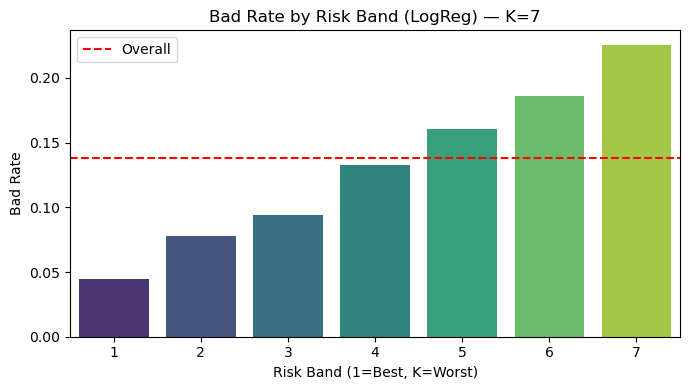

(   cluster   size  pct_portfolio  bad_rate    ci_low   ci_high  \
 0        1   5012       0.100058  0.044294  0.038938  0.050347   
 1        2   4963       0.099080  0.077776  0.070647  0.085558   
 2        3   5101       0.101835  0.094295  0.086578  0.102623   
 3        4  14891       0.297279  0.132563  0.127211  0.138105   
 4        5   7691       0.153541  0.160577  0.152542  0.168952   
 
    lift_vs_overall   age_mean  age_median  income_delta_percentage_mean  \
 0         0.321274  38.344374        38.0                    -38.898927   
 1         0.564126  40.663913        40.0                    -16.189922   
 2         0.683948  40.702607        40.0                    -17.930346   
 3         0.961516  40.210933        39.0                    -32.814976   
 4         1.164709  42.196593        42.0                    -27.839658   
 
    income_delta_percentage_median marital_status_mode  \
 0                      -39.725057             Married   
 1                    

In [21]:
# Profile bands and significance tests
from utiles import proportion_ci_wilson, compute_cluster_profiles, chi_square_test_cluster_target, pairwise_bad_rate_ztests
import seaborn as sns
import matplotlib.pyplot as plt

# Use the same profiling utilities, treating risk_band like a cluster id
profiles_bands = compute_cluster_profiles(
    df.rename(columns={'risk_band':'cluster'}),
    cluster_col='cluster',
    target_col='target',
    numeric_cols=numeric_cols,
    categorical_cols=categorical_cols,
)

# Global test and pairwise tests across bands
chi2_b, p_chi_b, dof_b, expected_df_b = chi_square_test_cluster_target(
    df.rename(columns={'risk_band':'cluster'}),
    cluster_col='cluster',
    target_col='target'
)
print(f"Bands chi-square = {chi2_b:.2f} (dof={dof_b}) p-value={p_chi_b:.3e}")

pairwise_bands = pairwise_bad_rate_ztests(
    df.rename(columns={'risk_band':'cluster'}),
    cluster_col='cluster',
    target_col='target',
    adjust='bh'
)

# Visualize bad rate by band
plt.figure(figsize=(7,4))
order = profiles_bands.sort_values('cluster').cluster
sns.barplot(data=profiles_bands, x='cluster', y='bad_rate', order=order, palette='viridis')
plt.axhline(df['target'].mean(), color='red', linestyle='--', label='Overall')
plt.xlabel('Risk Band (1=Best, K=Worst)')
plt.ylabel('Bad Rate')
plt.title(f'Bad Rate by Risk Band (LogReg) — K={int(df["risk_band"].nunique())}')
plt.legend()
plt.tight_layout()
fig_bands = plt.gcf()
plt.show()

profiles_bands.head(), pairwise_bands.head(10)

In [22]:
# Export artifacts for Logistic Regression bands
from pathlib import Path
import pickle

OUTPUT_BANDS = Path('customer_segmantation_unbaked_logreg_bands_v1.0')
OUTPUT_BANDS.mkdir(exist_ok=True, parents=True)

# Save core tables
cols_bands = ['customer_id', 'risk_band', 'pd_score', 'target'] + numeric_cols + categorical_cols
df[cols_bands].to_csv(OUTPUT_BANDS / 'customers_with_risk_bands.csv', index=False)
profiles_bands.to_csv(OUTPUT_BANDS / 'band_profiles.csv', index=False)
pairwise_bands.to_csv(OUTPUT_BANDS / 'band_pairwise_bad_rate_tests.csv', index=False)

# Save plot
fig_bands.savefig(OUTPUT_BANDS / 'band_bad_rates.png', dpi=300)

# Save model and encoder
with open(OUTPUT_BANDS / 'model_logreg.pkl', 'wb') as f:
    pickle.dump(logreg, f)
with open(OUTPUT_BANDS / 'encoder_ordinal.pkl', 'wb') as f:
    pickle.dump(enc, f)

# Persist edges for reproducibility
np.savetxt(OUTPUT_BANDS / 'band_edges.txt', edges, fmt='%.10f')

# Save a simple summary
summary_bands = {
    'version': 'v1.1',
    'output_dir': str(OUTPUT_BANDS.resolve()),
    'overall_bad_rate': float(df['target'].mean()),
    'n_bands': int(df['risk_band'].nunique()),
    'bands': [int(b) for b in sorted(df['risk_band'].unique())],
    'cuts': edges.tolist(),
    'artifacts': [
        'customers_with_risk_bands.csv',
        'band_profiles.csv',
        'band_pairwise_bad_rate_tests.csv',
        'band_bad_rates.png',
        'band_edges.txt',
        'model_logreg.pkl',
        'encoder_ordinal.pkl'
    ],
}
with open(OUTPUT_BANDS / 'summary.json', 'w') as f:
    json.dump(summary_bands, f, indent=2)

print('Bands artifacts saved in', OUTPUT_BANDS.resolve())

Bands artifacts saved in /home/ali/repos/creadit_risk/customer_segmantation/customer_segmantation_unbaked_logreg_bands_v1.0


### Notes on interpretation and customization

- Smart bands: We build initial quantile bins on `pd_score` and iteratively merge adjacent bins until each band is large enough and adjacent bad-rate differences are statistically significant (two-proportion z-test, p<0.05 via normal approximation). We also cap the number of bands.
- Tuning knobs:
  - `init_bins`: more starting bins can find finer structure but may take longer; defaults to 20.
  - `min_bin_size`: minimum share per band (e.g., 0.05 = 5%).
  - `max_bands`: upper bound on number of bands (default 8).
  - `alpha`: significance level for adjacency tests (default 0.05).
- Alternative: For equal-sized segments, use quantile bands with `pd.qcut(df['pd_score'], q=5, labels=[1,2,3,4,5])`.
- Directionality: Band 1 is best (lowest risk), Band K is worst (highest risk).